# Facial Keypoint Detection


## Initialize Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Convolution2D, BatchNormalization, Flatten
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPool2D
from tensorflow.keras.optimizers import Nadam
from keras import backend
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import cv2
import os, gc, json, math

Using TensorFlow backend.
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.2.4
1.13.1


## Functions

In [3]:
def convert_pixels(data):
    """
    Convert pixels to the right intensity 0-1 and in a square matrix.
    """
    data = np.array([row.split(' ') for row in data['Image']],dtype='float') / 255.0
    data = data.reshape(-1,96,96,1)
    return(data)

In [4]:
def view_img(sample_img,coord=None):
    """
    Display an image. For debugging, display a coordinate on the image.
    input:
        - sample_img: numpy array. image to be displayed
        - coord: lst. of coordinates in form [[x_coordinate,y_coordinate],[x_coordinate,y_coordinate]]
    TODO handle multiple coordinates. Work out bugs with multiple coordinates
    """
    plt.figure()
    plt.imshow(sample_img.reshape(96,96),cmap='gray')
    if coord is not None:
        plt.scatter(coord[0],coord[1],marker = '*',c='r')
    plt.show()

In [5]:
def get_facial_keypoints(data,ind):
    """
    Structure the coordinates for all facial keypoints for a single image.
    inputs:
        - data: numpy array containing rows as each image sample and columns as facial keypoint coordinates
        - ind: index of the image
    output:
        - numpy array with format [[list of x-coordinates],[list of y-coordinates]]
    """
    data[ind]
    it = iter(data[ind])
    x_coord = []
    y_coord = []

    for x in it:
        x_coord.append(x)
        y_coord.append(next(it))
    
    return(np.array([x_coord,y_coord]))


## Import Data

In [6]:
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()    

0


In [7]:
if not os.path.exists('../output/'):
    os.makedirs('../output/model')
    os.makedirs('../output/history')
    
    
model_dir = "../output/model/"
history_dir = "../output/history/"

train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
train_data = pd.read_csv(train_file)  
#test_data = pd.read_csv(test_file)


bad_samples = [1747, 1731, 1877, 1881, 1979, 2199, 2289, 2321, 2453, 3173, 3296, 3447, 4180, 6859,
              2090, 2175, 1907, 2562, 2818, 3296, 3447, 4263, 4482, 4490, 4636, 5059, 6493, 6585, 6906]

train_data = train_data.drop(bad_samples).reset_index(drop=True)
train_clean = train_data.dropna()

## Exploratory Data Analysis

In [8]:
train_clean.shape

(2140, 31)

Create training vector with images and normalize thee

In [9]:
x_train = convert_pixels(train_data)
x_clean = convert_pixels(train_clean)
y_train = train_data[[col for col in train_data.columns if col != 'Image']].to_numpy()
y_clean = train_clean[[col for col in train_clean.columns if col != 'Image']].to_numpy()

Generate labels 

In [10]:

#imputer = KNNImputer(n_neighbors=3, weights='distance')

imputer = IterativeImputer(max_iter=1000, tol=0.01, random_state=1)
y_train = imputer.fit_transform(y_train)

#imputer = IterativeImputer(max_iter=1000, tol=0.01, random_state=2)
#y_clean = imputer.fit_transform(y_clean)

bad_bottom_lip = [210, 350, 499, 512, 810, 839, 895, 1058, 1194,1230, 1245, 1546, 1548]
for sample in bad_bottom_lip:
    y_train[sample][29] = 94
    y_train[sample][28] = y_train[sample][26]
   

## Feature Engineering

### Set feature engineering parameters

In [11]:
fill_na = False
add_flip_horiz = True
add_blur_img = False
add_rotate_img = False
orig_x_train = x_clean.copy()
#orig_y_train = y_clean.copy()


### Fill NA in the training labels.

In [12]:
if fill_na:
    # https://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns
    # get column means
    col_mean = np.nanmean(y_train,axis=0)

    # find the x,y indices that are missing from y_train
    inds = np.where(np.isnan(y_train))

    # fill in missing values in y_train with the column means. "take" is much more efficient than fancy indexing
    y_train[inds] = np.take(col_mean, inds[1])


### Flip images horizontally and add to the training data

In [13]:
def flip_img_horiz(train_data):
    """
    Flip images horizontally for all training images
    """
    # Flip images
    x_train = convert_pixels(train_data)
    flip_img = np.array([np.fliplr(x_train[[ind]][0]) for ind in range(x_train.shape[0])])
    
    # Flip coordinates
    train_data_flip = train_data.copy()
    x_columns = [col for col in train_data.columns if '_x' in col]
    train_data_flip[x_columns] = train_data[x_columns].applymap(lambda x: 96-x)
    
    #left and right are swapped so undo
    left_columns = [col for col in train_data.columns if 'left' in col]
    right_columns = [col for col in train_data.columns if 'right' in col]
    train_data_flip[left_columns+right_columns] = train_data_flip[right_columns+left_columns]
    
    flip_coord = train_data_flip[[col for col in train_data if col != 'Image']].to_numpy()
    return(flip_img,flip_coord)

if add_flip_horiz:
    # Apply the augmentation and add the new data to the training set
    flipped_img,flipped_coord = flip_img_horiz(train_clean)
    
   
    x_train = np.append(x_train,flipped_img,axis=0)
    y_train = np.append(y_train,flipped_coord,axis=0)
    
    

### Add Gaussian blurring with a 5x5 filter with $\sigma$ = 2.

In [14]:
y_train.shape

(9162, 30)

In [15]:
def blur_img():
    """
    Add Gaussian blurring to the images
    """
    # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html
    blur_img = np.array([cv2.GaussianBlur(orig_x_train[[ind]][0],(5,5),2).reshape(96,96,1) for ind in range(orig_x_train.shape[0])])
    
    return(blur_img)

if add_blur_img:
    x_train = np.append(x_train,blur_img(),axis=0)
    y_train = np.append(y_train,orig_y_train,axis=0)

In [16]:
def rotate_img(x_train, y_train):
    """"
    Rotate images by angles between [5, 10, 14 degrees]
    """
    angles = [5, -5, 10, -10, 14, -14]
    b = np.ones((1,3))
    rows,cols = (96,96)
    x_train_rot = []
    y_train_rot = y_train.copy()
    M_angles = [cv2.getRotationMatrix2D((cols/2,rows/2),angle,1) for angle in angles]
    
    for i in range(x_train.shape[0]):
        #M = cv2.getRotationMatrix2D((cols/2,rows/2),np.random.choice(angles,1),1)
        M = M_angles[np.random.choice(len(M_angles))]
        x_train_rot.append((cv2.warpAffine(x_train[[i]].reshape(rows,cols,1),M,(cols,rows)).reshape(96,96,1)))
       
        #apply affine transformation to (x,y) labels
        for j in range(int(y_train.shape[1]/2)):
            b[:,0:2] = y_train[i,2*j:2*j+2]
            y_train_rot[i,2*j:2*j+2] = np.dot(b,M.transpose()) 
    
    x_train_rot = np.array(x_train_rot)
    return x_train_rot, y_train_rot

if add_rotate_img:
    
    x_rotate, y_rotate = rotate_img(x_train,y_train)
    x_train = np.append(x_train,x_rotate,axis=0)
    y_train = np.append(y_train,y_rotate,axis=0)   
    

## Modeling

In [17]:
# Define callback function if detailed log required
class History(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.train_rmse = []
        self.val_rmse = []
        self.val_loss = []

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.train_rmse.append(logs.get('rmse'))
        
    def on_epoch_end(self, batch, logs={}):    
        self.val_rmse.append(logs.get('val_rmse'))
        self.val_loss.append(logs.get('val_loss'))
        
# Implement ModelCheckPoint callback function to save CNN model
class CNN_ModelCheckpoint(tensorflow.keras.callbacks.Callback):

    def __init__(self, model, filename):
        self.filename = filename
        self.cnn_model = model

    def on_train_begin(self, logs={}):
        self.max_val_rmse = math.inf
        
 
    def on_epoch_end(self, batch, logs={}):    
        val_rmse = logs.get('val_rmse')
        if(val_rmse < self.max_val_rmse):
           self.max_val_rmse = val_rmse
           self.cnn_model.save_weights(self.filename)


In [23]:
def base_model():
    model_input = Input(shape=(96,96,1))

    x = Convolution2D(32, (3,3), padding='same', use_bias=False)(model_input)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(32, (3,3), padding='same', use_bias=False)(model_input)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)
    x = Convolution2D(64, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(64, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)
    x = Convolution2D(96, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(96, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)
    x = Convolution2D(128, (3,3),padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(128, (3,3),padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)
    x = Convolution2D(256, (3,3),padding='same',use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(256, (3,3),padding='same',use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)
    x = Convolution2D(512, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(512, (3,3), activation='relu', padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.1)(x)
    model_output = Dense(30)(x)
    model = Model(model_input, model_output, name="base_model")
    return model

model = base_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_v1_12 (B (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 64)        18432     
__________

In [24]:
# Custom RMSE metric
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

#from tensorflow.keras.optimizers.schedules import InverseTimeDecay

# Use Nadam optimizer with variable learning rate
optimizer = Nadam(lr=0.00001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)


# Loss: MSE and Metric = RMSE
model.compile(optimizer= optimizer, 
              loss='mean_squared_error',
              metrics=[rmse])

#Callback to save the best model
saveBase_Model = CNN_ModelCheckpoint(model, model_dir+"base_model_weights_1.h5")

#define callback functions
callbacks = [#EarlyStopping(monitor='val_rmse', patience=3, verbose=2),
             saveBase_Model]

Run for 1000 epochs and keeping 20% train-valid split

Train on 7329 samples, validate on 1833 samples
Epoch 1/1000
7329/7329 [==============================] - 11s 2ms/sample - loss: 2528.6959 - rmse: 50.2460 - val_loss: 2631.5144 - val_rmse: 51.2785
Epoch 2/1000
7329/7329 [==============================] - 6s 770us/sample - loss: 2038.0228 - rmse: 45.0622 - val_loss: 2624.6580 - val_rmse: 51.2116
Epoch 3/1000
7329/7329 [==============================] - 6s 775us/sample - loss: 1476.1080 - rmse: 38.3198 - val_loss: 2593.1172 - val_rmse: 50.9027
Epoch 4/1000
7329/7329 [==============================] - 6s 781us/sample - loss: 1060.6232 - rmse: 32.4605 - val_loss: 2500.1241 - val_rmse: 49.9810
Epoch 5/1000
7329/7329 [==============================] - 6s 879us/sample - loss: 757.2951 - rmse: 27.4008 - val_loss: 2329.3429 - val_rmse: 48.2425
Epoch 6/1000
7329/7329 [==============================] - 6s 801us/sample - loss: 531.9613 - rmse: 22.9364 - val_loss: 2100.3646 - val_rmse: 45.8079
Epoch 7/1000
7329/7329 [==============================]

Epoch 57/1000
7329/7329 [==============================] - 5s 744us/sample - loss: 34.4765 - rmse: 5.7053 - val_loss: 11.8499 - val_rmse: 3.2537
Epoch 58/1000
7329/7329 [==============================] - 5s 744us/sample - loss: 34.5173 - rmse: 5.7095 - val_loss: 11.7431 - val_rmse: 3.2411
Epoch 59/1000
7329/7329 [==============================] - 5s 745us/sample - loss: 34.1198 - rmse: 5.6766 - val_loss: 11.7307 - val_rmse: 3.2385
Epoch 60/1000
7329/7329 [==============================] - 5s 750us/sample - loss: 33.9526 - rmse: 5.6625 - val_loss: 11.7162 - val_rmse: 3.2359
Epoch 61/1000
7329/7329 [==============================] - 5s 748us/sample - loss: 33.9819 - rmse: 5.6646 - val_loss: 11.6828 - val_rmse: 3.2299
Epoch 62/1000
7329/7329 [==============================] - 5s 727us/sample - loss: 33.8219 - rmse: 5.6533 - val_loss: 11.7425 - val_rmse: 3.2384
Epoch 63/1000
7329/7329 [==============================] - 5s 741us/sample - loss: 33.5163 - rmse: 5.6247 - val_loss: 11.6048 - va

7329/7329 [==============================] - 5s 719us/sample - loss: 23.2870 - rmse: 4.6800 - val_loss: 7.0146 - val_rmse: 2.4843
Epoch 114/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 23.1511 - rmse: 4.6707 - val_loss: 7.1024 - val_rmse: 2.5056
Epoch 115/1000
7329/7329 [==============================] - 5s 712us/sample - loss: 22.6989 - rmse: 4.6228 - val_loss: 6.9988 - val_rmse: 2.4848
Epoch 116/1000
7329/7329 [==============================] - 5s 726us/sample - loss: 22.8171 - rmse: 4.6353 - val_loss: 6.8524 - val_rmse: 2.4563
Epoch 117/1000
7329/7329 [==============================] - 5s 712us/sample - loss: 22.6186 - rmse: 4.6165 - val_loss: 6.9827 - val_rmse: 2.4842
Epoch 118/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 22.5538 - rmse: 4.6097 - val_loss: 6.8955 - val_rmse: 2.4678
Epoch 119/1000
7329/7329 [==============================] - 5s 729us/sample - loss: 22.2975 - rmse: 4.5870 - val_loss: 6.7316 - val_rmse: 2.4316


7329/7329 [==============================] - 5s 714us/sample - loss: 16.1100 - rmse: 3.9119 - val_loss: 4.8692 - val_rmse: 2.0448
Epoch 170/1000
7329/7329 [==============================] - 5s 726us/sample - loss: 16.0177 - rmse: 3.8969 - val_loss: 4.7562 - val_rmse: 2.0218
Epoch 171/1000
7329/7329 [==============================] - 5s 713us/sample - loss: 15.9239 - rmse: 3.8909 - val_loss: 5.0731 - val_rmse: 2.0891
Epoch 172/1000
7329/7329 [==============================] - 5s 729us/sample - loss: 15.8477 - rmse: 3.8814 - val_loss: 4.5771 - val_rmse: 1.9823
Epoch 173/1000
7329/7329 [==============================] - 5s 713us/sample - loss: 15.8505 - rmse: 3.8846 - val_loss: 4.7182 - val_rmse: 2.0090
Epoch 174/1000
7329/7329 [==============================] - 5s 727us/sample - loss: 15.7613 - rmse: 3.8680 - val_loss: 4.5230 - val_rmse: 1.9679
Epoch 175/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 15.6252 - rmse: 3.8513 - val_loss: 4.7800 - val_rmse: 2.0238


7329/7329 [==============================] - 5s 710us/sample - loss: 11.8723 - rmse: 3.3666 - val_loss: 4.0564 - val_rmse: 1.8575
Epoch 226/1000
7329/7329 [==============================] - 5s 713us/sample - loss: 11.8193 - rmse: 3.3591 - val_loss: 4.2048 - val_rmse: 1.8921
Epoch 227/1000
7329/7329 [==============================] - 5s 716us/sample - loss: 11.6767 - rmse: 3.3369 - val_loss: 4.0797 - val_rmse: 1.8625
Epoch 228/1000
7329/7329 [==============================] - 5s 729us/sample - loss: 11.7023 - rmse: 3.3442 - val_loss: 3.8179 - val_rmse: 1.8010
Epoch 229/1000
7329/7329 [==============================] - 5s 712us/sample - loss: 11.6640 - rmse: 3.3368 - val_loss: 4.0408 - val_rmse: 1.8487
Epoch 230/1000
7329/7329 [==============================] - 5s 715us/sample - loss: 11.5199 - rmse: 3.3189 - val_loss: 3.8859 - val_rmse: 1.8162
Epoch 231/1000
7329/7329 [==============================] - 5s 712us/sample - loss: 11.5712 - rmse: 3.3276 - val_loss: 4.2831 - val_rmse: 1.9103


Epoch 282/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 9.1306 - rmse: 2.9529 - val_loss: 3.6935 - val_rmse: 1.7729
Epoch 283/1000
7329/7329 [==============================] - 5s 712us/sample - loss: 9.1351 - rmse: 2.9553 - val_loss: 3.4864 - val_rmse: 1.7136
Epoch 284/1000
7329/7329 [==============================] - 5s 728us/sample - loss: 9.0857 - rmse: 2.9472 - val_loss: 3.4253 - val_rmse: 1.6983
Epoch 285/1000
7329/7329 [==============================] - 5s 729us/sample - loss: 8.9166 - rmse: 2.9205 - val_loss: 3.4110 - val_rmse: 1.6952
Epoch 286/1000
7329/7329 [==============================] - 5s 713us/sample - loss: 8.9255 - rmse: 2.9200 - val_loss: 3.7088 - val_rmse: 1.7662
Epoch 287/1000
7329/7329 [==============================] - 5s 716us/sample - loss: 8.8617 - rmse: 2.9112 - val_loss: 3.8951 - val_rmse: 1.8177
Epoch 288/1000
7329/7329 [==============================] - 5s 727us/sample - loss: 8.9114 - rmse: 2.9169 - val_loss: 3.3617 - val_rmse:

Epoch 339/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 7.3592 - rmse: 2.6465 - val_loss: 3.2252 - val_rmse: 1.6423
Epoch 340/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 7.3320 - rmse: 2.6416 - val_loss: 3.2798 - val_rmse: 1.6534
Epoch 341/1000
7329/7329 [==============================] - 5s 712us/sample - loss: 7.2410 - rmse: 2.6269 - val_loss: 3.1535 - val_rmse: 1.6207
Epoch 342/1000
7329/7329 [==============================] - 5s 712us/sample - loss: 7.2594 - rmse: 2.6300 - val_loss: 3.4774 - val_rmse: 1.7114
Epoch 343/1000
7329/7329 [==============================] - 5s 713us/sample - loss: 7.2135 - rmse: 2.6218 - val_loss: 3.2682 - val_rmse: 1.6549
Epoch 344/1000
7329/7329 [==============================] - 5s 713us/sample - loss: 7.1736 - rmse: 2.6178 - val_loss: 3.1223 - val_rmse: 1.6174
Epoch 345/1000
7329/7329 [==============================] - 5s 712us/sample - loss: 7.0947 - rmse: 2.6007 - val_loss: 3.3135 - val_rmse:

Epoch 396/1000
7329/7329 [==============================] - 5s 710us/sample - loss: 6.1393 - rmse: 2.4157 - val_loss: 2.9948 - val_rmse: 1.5880
Epoch 397/1000
7329/7329 [==============================] - 5s 714us/sample - loss: 6.0437 - rmse: 2.3969 - val_loss: 3.3995 - val_rmse: 1.6831
Epoch 398/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 6.0274 - rmse: 2.3918 - val_loss: 3.1101 - val_rmse: 1.6037
Epoch 399/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 6.0865 - rmse: 2.4033 - val_loss: 2.9879 - val_rmse: 1.5760
Epoch 400/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 6.0660 - rmse: 2.3995 - val_loss: 2.9394 - val_rmse: 1.5655
Epoch 401/1000
7329/7329 [==============================] - 5s 710us/sample - loss: 6.0783 - rmse: 2.3987 - val_loss: 2.9359 - val_rmse: 1.5709
Epoch 402/1000
7329/7329 [==============================] - 5s 709us/sample - loss: 6.0007 - rmse: 2.3871 - val_loss: 3.0680 - val_rmse:

Epoch 453/1000
7329/7329 [==============================] - 5s 712us/sample - loss: 5.2130 - rmse: 2.2212 - val_loss: 2.9287 - val_rmse: 1.5586
Epoch 454/1000
7329/7329 [==============================] - 5s 710us/sample - loss: 5.2615 - rmse: 2.2309 - val_loss: 3.0072 - val_rmse: 1.5777
Epoch 455/1000
7329/7329 [==============================] - 5s 710us/sample - loss: 5.2481 - rmse: 2.2281 - val_loss: 2.8757 - val_rmse: 1.5403
Epoch 456/1000
7329/7329 [==============================] - 5s 712us/sample - loss: 5.2353 - rmse: 2.2247 - val_loss: 2.9285 - val_rmse: 1.5551
Epoch 457/1000
7329/7329 [==============================] - 5s 710us/sample - loss: 5.2303 - rmse: 2.2250 - val_loss: 2.8356 - val_rmse: 1.5314
Epoch 458/1000
7329/7329 [==============================] - 5s 713us/sample - loss: 5.2349 - rmse: 2.2240 - val_loss: 2.9422 - val_rmse: 1.5569
Epoch 459/1000
7329/7329 [==============================] - 5s 730us/sample - loss: 5.2423 - rmse: 2.2264 - val_loss: 2.7599 - val_rmse:

Epoch 510/1000
7329/7329 [==============================] - 5s 725us/sample - loss: 4.6582 - rmse: 2.0945 - val_loss: 2.6744 - val_rmse: 1.4861
Epoch 511/1000
7329/7329 [==============================] - 5s 710us/sample - loss: 4.6493 - rmse: 2.0923 - val_loss: 2.7913 - val_rmse: 1.5131
Epoch 512/1000
7329/7329 [==============================] - 5s 728us/sample - loss: 4.6721 - rmse: 2.0968 - val_loss: 2.6477 - val_rmse: 1.4796
Epoch 513/1000
7329/7329 [==============================] - 5s 712us/sample - loss: 4.6364 - rmse: 2.0899 - val_loss: 2.7129 - val_rmse: 1.4957
Epoch 514/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 4.6504 - rmse: 2.0923 - val_loss: 2.8880 - val_rmse: 1.5480
Epoch 515/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 4.6356 - rmse: 2.0893 - val_loss: 2.7730 - val_rmse: 1.5082
Epoch 516/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 4.6172 - rmse: 2.0856 - val_loss: 2.7127 - val_rmse:

Epoch 567/1000
7329/7329 [==============================] - 5s 713us/sample - loss: 4.1613 - rmse: 1.9764 - val_loss: 2.7170 - val_rmse: 1.4900
Epoch 568/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 4.2179 - rmse: 1.9902 - val_loss: 2.6728 - val_rmse: 1.4804
Epoch 569/1000
7329/7329 [==============================] - 5s 711us/sample - loss: 4.1756 - rmse: 1.9775 - val_loss: 2.7231 - val_rmse: 1.4929
Epoch 570/1000
7329/7329 [==============================] - 5s 716us/sample - loss: 4.1815 - rmse: 1.9800 - val_loss: 2.6500 - val_rmse: 1.4716
Epoch 571/1000
7329/7329 [==============================] - 5s 728us/sample - loss: 4.1313 - rmse: 1.9688 - val_loss: 2.5684 - val_rmse: 1.4532
Epoch 572/1000
7329/7329 [==============================] - 5s 715us/sample - loss: 4.1526 - rmse: 1.9740 - val_loss: 2.6458 - val_rmse: 1.4836
Epoch 573/1000
7329/7329 [==============================] - 5s 713us/sample - loss: 4.1199 - rmse: 1.9654 - val_loss: 2.6919 - val_rmse:

Epoch 624/1000
7329/7329 [==============================] - 5s 681us/sample - loss: 3.8788 - rmse: 1.9012 - val_loss: 2.6420 - val_rmse: 1.4693
Epoch 625/1000
7329/7329 [==============================] - 5s 675us/sample - loss: 3.8560 - rmse: 1.8961 - val_loss: 2.6254 - val_rmse: 1.4634
Epoch 626/1000
7329/7329 [==============================] - 5s 676us/sample - loss: 3.8311 - rmse: 1.8912 - val_loss: 2.7969 - val_rmse: 1.5083
Epoch 627/1000
7329/7329 [==============================] - 5s 676us/sample - loss: 3.8493 - rmse: 1.8968 - val_loss: 2.5942 - val_rmse: 1.4543
Epoch 628/1000
7329/7329 [==============================] - 5s 674us/sample - loss: 3.7932 - rmse: 1.8822 - val_loss: 2.8615 - val_rmse: 1.5376
Epoch 629/1000
7329/7329 [==============================] - 5s 676us/sample - loss: 3.8187 - rmse: 1.8873 - val_loss: 2.5829 - val_rmse: 1.4543
Epoch 630/1000
7329/7329 [==============================] - 5s 675us/sample - loss: 3.8243 - rmse: 1.8884 - val_loss: 2.6800 - val_rmse:

Epoch 681/1000
7329/7329 [==============================] - 5s 681us/sample - loss: 3.5327 - rmse: 1.8127 - val_loss: 2.5616 - val_rmse: 1.4489
Epoch 682/1000
7329/7329 [==============================] - 5s 679us/sample - loss: 3.6130 - rmse: 1.8340 - val_loss: 2.5792 - val_rmse: 1.4475
Epoch 683/1000
7329/7329 [==============================] - 5s 679us/sample - loss: 3.5666 - rmse: 1.8195 - val_loss: 2.6334 - val_rmse: 1.4628
Epoch 684/1000
7329/7329 [==============================] - 5s 678us/sample - loss: 3.4983 - rmse: 1.8058 - val_loss: 2.5447 - val_rmse: 1.4408
Epoch 685/1000
7329/7329 [==============================] - 5s 682us/sample - loss: 3.5845 - rmse: 1.8244 - val_loss: 2.5095 - val_rmse: 1.4360
Epoch 686/1000
7329/7329 [==============================] - 5s 687us/sample - loss: 3.5294 - rmse: 1.8108 - val_loss: 2.5496 - val_rmse: 1.4395
Epoch 687/1000
7329/7329 [==============================] - 5s 677us/sample - loss: 3.5403 - rmse: 1.8137 - val_loss: 2.5732 - val_rmse:

Epoch 738/1000
7329/7329 [==============================] - 5s 687us/sample - loss: 3.2867 - rmse: 1.7460 - val_loss: 2.5287 - val_rmse: 1.4320
Epoch 739/1000
7329/7329 [==============================] - 5s 675us/sample - loss: 3.3181 - rmse: 1.7527 - val_loss: 2.4486 - val_rmse: 1.4246
Epoch 740/1000
7329/7329 [==============================] - 5s 677us/sample - loss: 3.3114 - rmse: 1.7516 - val_loss: 2.5005 - val_rmse: 1.4273
Epoch 741/1000
7329/7329 [==============================] - 5s 679us/sample - loss: 3.3565 - rmse: 1.7623 - val_loss: 2.5856 - val_rmse: 1.4458
Epoch 742/1000
7329/7329 [==============================] - 5s 676us/sample - loss: 3.3155 - rmse: 1.7529 - val_loss: 2.4554 - val_rmse: 1.4121
Epoch 743/1000
7329/7329 [==============================] - 5s 677us/sample - loss: 3.2895 - rmse: 1.7436 - val_loss: 2.5172 - val_rmse: 1.4264
Epoch 744/1000
7329/7329 [==============================] - 5s 674us/sample - loss: 3.2922 - rmse: 1.7463 - val_loss: 2.5132 - val_rmse:

Epoch 795/1000
7329/7329 [==============================] - 5s 677us/sample - loss: 3.1115 - rmse: 1.6927 - val_loss: 2.5581 - val_rmse: 1.4365
Epoch 796/1000
7329/7329 [==============================] - 5s 676us/sample - loss: 3.1507 - rmse: 1.7020 - val_loss: 2.4681 - val_rmse: 1.4105
Epoch 797/1000
7329/7329 [==============================] - 5s 677us/sample - loss: 3.1234 - rmse: 1.6961 - val_loss: 2.4548 - val_rmse: 1.4108
Epoch 798/1000
7329/7329 [==============================] - 5s 682us/sample - loss: 3.1219 - rmse: 1.6957 - val_loss: 2.4836 - val_rmse: 1.4171
Epoch 799/1000
7329/7329 [==============================] - 5s 683us/sample - loss: 3.1100 - rmse: 1.6941 - val_loss: 2.5608 - val_rmse: 1.4333
Epoch 800/1000
7329/7329 [==============================] - 5s 678us/sample - loss: 3.1380 - rmse: 1.7006 - val_loss: 2.4571 - val_rmse: 1.4113
Epoch 801/1000
7329/7329 [==============================] - 5s 676us/sample - loss: 3.0980 - rmse: 1.6900 - val_loss: 2.5906 - val_rmse:

Epoch 852/1000
7329/7329 [==============================] - 5s 679us/sample - loss: 2.9085 - rmse: 1.6336 - val_loss: 2.4683 - val_rmse: 1.4090
Epoch 853/1000
7329/7329 [==============================] - 5s 675us/sample - loss: 2.9591 - rmse: 1.6497 - val_loss: 2.4449 - val_rmse: 1.4061
Epoch 854/1000
7329/7329 [==============================] - 5s 679us/sample - loss: 2.9727 - rmse: 1.6523 - val_loss: 2.5306 - val_rmse: 1.4236
Epoch 855/1000
7329/7329 [==============================] - 5s 676us/sample - loss: 2.8719 - rmse: 1.6265 - val_loss: 2.4939 - val_rmse: 1.4177
Epoch 856/1000
7329/7329 [==============================] - 5s 678us/sample - loss: 2.9177 - rmse: 1.6388 - val_loss: 2.3686 - val_rmse: 1.3863
Epoch 857/1000
7329/7329 [==============================] - 5s 676us/sample - loss: 2.9531 - rmse: 1.6478 - val_loss: 2.3929 - val_rmse: 1.3884
Epoch 858/1000
7329/7329 [==============================] - 5s 687us/sample - loss: 2.9764 - rmse: 1.6504 - val_loss: 2.4537 - val_rmse:

Epoch 909/1000
7329/7329 [==============================] - 5s 677us/sample - loss: 2.8296 - rmse: 1.6073 - val_loss: 2.3826 - val_rmse: 1.3852
Epoch 910/1000
7329/7329 [==============================] - 5s 675us/sample - loss: 2.8139 - rmse: 1.6044 - val_loss: 2.3770 - val_rmse: 1.3815
Epoch 911/1000
7329/7329 [==============================] - 5s 679us/sample - loss: 2.7878 - rmse: 1.5960 - val_loss: 2.4183 - val_rmse: 1.3948
Epoch 912/1000
7329/7329 [==============================] - 5s 675us/sample - loss: 2.7751 - rmse: 1.5947 - val_loss: 2.4094 - val_rmse: 1.3988
Epoch 913/1000
7329/7329 [==============================] - 5s 676us/sample - loss: 2.7768 - rmse: 1.5951 - val_loss: 2.4272 - val_rmse: 1.3934
Epoch 914/1000
7329/7329 [==============================] - 5s 678us/sample - loss: 2.8167 - rmse: 1.6053 - val_loss: 2.4195 - val_rmse: 1.3900
Epoch 915/1000
7329/7329 [==============================] - 5s 677us/sample - loss: 2.7585 - rmse: 1.5896 - val_loss: 2.4300 - val_rmse:

Epoch 966/1000
7329/7329 [==============================] - 5s 676us/sample - loss: 2.6734 - rmse: 1.5600 - val_loss: 2.3626 - val_rmse: 1.3810
Epoch 967/1000
7329/7329 [==============================] - 5s 678us/sample - loss: 2.6088 - rmse: 1.5448 - val_loss: 2.3669 - val_rmse: 1.3745
Epoch 968/1000
7329/7329 [==============================] - 5s 675us/sample - loss: 2.6639 - rmse: 1.5570 - val_loss: 2.3622 - val_rmse: 1.3780
Epoch 969/1000
7329/7329 [==============================] - 5s 677us/sample - loss: 2.6946 - rmse: 1.5660 - val_loss: 2.4501 - val_rmse: 1.3964
Epoch 970/1000
7329/7329 [==============================] - 5s 678us/sample - loss: 2.7007 - rmse: 1.5673 - val_loss: 2.3465 - val_rmse: 1.3823
Epoch 971/1000
7329/7329 [==============================] - 5s 677us/sample - loss: 2.6336 - rmse: 1.5497 - val_loss: 2.4308 - val_rmse: 1.3921
Epoch 972/1000
7329/7329 [==============================] - 5s 676us/sample - loss: 2.6731 - rmse: 1.5583 - val_loss: 2.3617 - val_rmse:

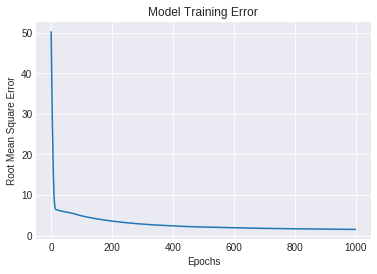

In [25]:

USE_SAVED_MODEL = False

if USE_SAVED_MODEL == False:
    history = model.fit(x_train,
                    y_train,
                    epochs = 1000,
                    batch_size = 256,
                    validation_split = 0.2, #data = (x_test, y_test),
                    callbacks = callbacks
                    )
    plt.style.use('seaborn-darkgrid')
    plt.plot(history.history['rmse'])
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Square Error')
    plt.title('Model Training Error')
    plt.show() 
    
else:
    model.load_weights(model_dir+"base_model_weights_1.h5")
                    

In [26]:
lookid_dir = '../input/IdLookupTable.csv'
lookid_data = pd.read_csv(lookid_dir)
test_data = pd.read_csv(test_file)

x_test = []
for i in range(0,len(test_data)):
    img = test_data['Image'][i].split(' ')
    x_test.append(img)
    
x_test = np.array(x_test,dtype = 'float')
x_test = x_test/255.0
x_test = x_test.reshape(-1,96,96,1)    

y_test = model.predict(x_test)
y_test = np.clip(y_test,0,96)

lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pred_list = list(y_test)

rowid = list(lookid_data['RowId'])

feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))
    
    
submit_data = []
for x,y in zip(imageID,feature):
    submit_data.append(pred_list[x][y])
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(submit_data,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)
submission.to_csv('../output/w207_base_submission_1.csv',index = False)    

In [22]:
if 0:
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
    try:
        del model # this is from global space - change this as you need
    except:
        print("Model clear Failed")
    print(gc.collect())    